In [1]:
import torch
import numpy as np
from nn.rrdbunet import UNetRRDB2 # Load a modeltype
#Plotting stuff
from utils.visualize import plot_matrices, plot_insulation_scores
from utils.metrics import calculate_insulation_score
from utils.helpers import get_device


/home/operator/mambaforge/envs/ccut-test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#instatitate model and push to device
device  = get_device()
unet = UNetRRDB2(in_channels=1, out_channels=1, features=[64, 128, 256, 512, 1024]).to(device=device)

In [7]:
# Load weitghts from training
unet.load("unet-1024-40x40-porec-4x-tvloss.pth", device=device)

In [4]:
# Load low res and high res ccdata from numpy (can be created with 
#
# python convert_and_normalize_v3.py SRR11589414_1_4x_v2.mcool::/resolutions/50000 --prefix <filename_prefix> --output_path <your/outpudir/> --processes 9 --chromosomes 1-18  --cutoff 71 --norm
# cutoff is a value to cap all interactions at -> 71 is the 99.9th percentile for the pore-c data
# norm will norm the data between 0-1.
# This method prepares the data in numpy format making it easy to handle in python. Otherwise the the CC_Dataset class can achieve the same with hot-loading
# )

chr19_lr = np.load(
    "../data/porec-4x-perc999-hr_cutoff-norm-chr19-22-50k-chromosomes.npz"
)["chr19"]
chr19_hr = np.load(
    "../data/porec-perc999-hr_cutoff-norm-chr19-22-50k-chromosomes.npz"
)["chr19"]

In [5]:
# Predict a patch (device will be automagically the same as the model lives on if you don't specify otherwise)
unet.predict_patch(chr19_lr[200:240,200:240])

array([[0.97106147, 0.9964589 , 0.9970699 , ..., 0.01964162, 0.01658794,
        0.01469406],
       [0.98304653, 0.9985164 , 1.0006956 , ..., 0.01864215, 0.02216049,
        0.02287647],
       [0.97974163, 0.99542165, 0.99662215, ..., 0.02660236, 0.03170781,
        0.04488194],
       ...,
       [0.01843478, 0.01593214, 0.02283203, ..., 0.9935852 , 0.9854638 ,
        1.0372827 ],
       [0.01883786, 0.02146745, 0.026896  , ..., 1.0047839 , 1.0060279 ,
        0.98143196],
       [0.01460312, 0.01682229, 0.03311675, ..., 1.0112131 , 0.99745995,
        0.99342614]], dtype=float32)

In [8]:
# predict a whole chromosome (device will be automagically the same as the model lives on if you don't specify otherwise)
chr19_pred = unet.reconstruct_matrix(lr= chr19_lr, patch_size=40)

100%|██████████| 30/30 [03:01<00:00,  6.04s/it]


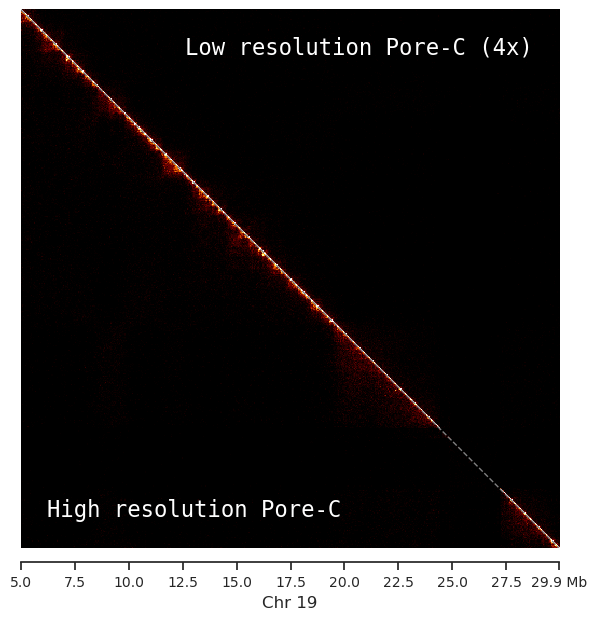

In [9]:
plot_matrices(
    np.squeeze(chr19_lr[100:600, 100:600]),
    np.squeeze(chr19_hr[100:600, 100:600]),
    chromosome="Chr 19",
    start_pos=100*50_000,
    resolution=50_000,
    cmap="afmhot",
    tick_interval=50,
    text_lower_left="High resolution Pore-C",
    text_upper_right="Low resolution Pore-C (4x)",
    diag=True,
    figsize=(7,7)
)

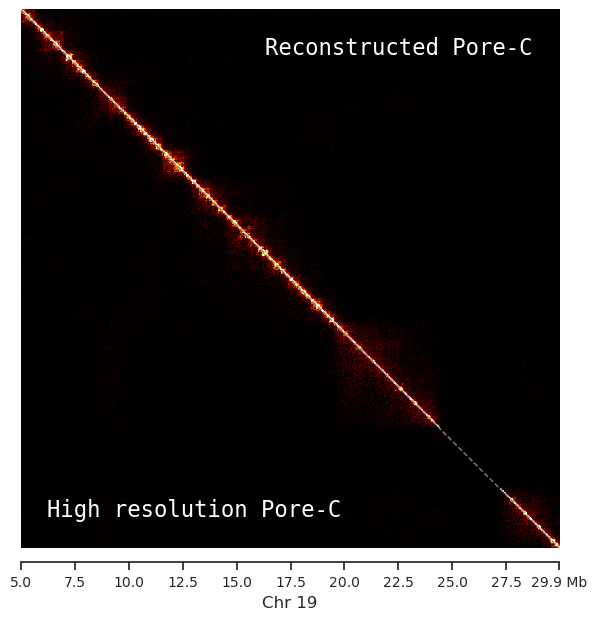

In [10]:
plot_matrices(
    np.squeeze(chr19_pred[100:600, 100:600]),
    np.squeeze(chr19_hr[100:600, 100:600]),
    chromosome="Chr 19",
    start_pos=100*50_000,
    resolution=50_000,
    cmap="afmhot",
    tick_interval=50,
    text_lower_left="High resolution Pore-C",
    text_upper_right="Reconstructed Pore-C",
    diag=True,
    figsize=(7,7)
)

In [11]:
# Calculate insulation profiles for biological validation
window_size1 = 3
insulation_scores_pred1 = calculate_insulation_score(chr19_pred, window_size1)
insulation_scores_lr1 = calculate_insulation_score(chr19_lr, window_size1)
insulation_scores_hr1 = calculate_insulation_score(chr19_hr, window_size1)
window_size2 = 5
insulation_scores_pred2 = calculate_insulation_score(chr19_pred, window_size2)
insulation_scores_lr2 = calculate_insulation_score(chr19_lr, window_size2)
insulation_scores_hr2 = calculate_insulation_score(chr19_hr, window_size2)

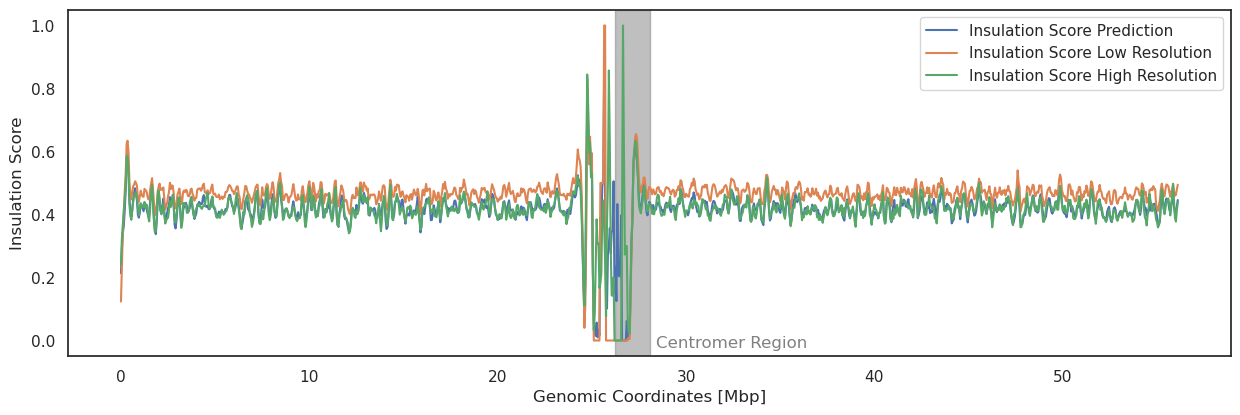

In [12]:
import matplotlib.pyplot as plt
import numpy as np


plot_insulation_scores(
    insulation_scores_pred1,
    insulation_scores_lr1,
    insulation_scores_hr1,
    start_pos=0,
    resolution=50_000,
    figsize=(15, 4.5),
)

In [ ]:
np.save('chr19_predictions_pore-c', chr19_pred)